In [2]:
!pip3 install anndata
!pip3 install scanpy

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 128 kB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 53 kB 8.3 MB/s  eta 0:00:01
     |████████████████████████████████| 2.8 MB 25.5 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 2.1 MB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 26.7 MB/s eta 0:00:01
     |████████████████████████████████| 56 kB 18.0 MB/s eta 0:00:01
     |████████████████████████████████| 232 kB 21.6 MB/s eta 0:00:01
     |████████████████████████████████| 90 kB 18.4 MB/s eta 0:00:01
     |████████████████████████████████| 9.8 MB 61.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 44.7 MB/s eta 0:00:01
     |████████████████████████

# Batch Integration

In [157]:
import anndata as ad
import scanpy as sc
extract_dir = "data/"
adata = ad.read_h5ad(extract_dir+'cleaned_processed_frogtail.h5ad') # ad.read_h5ad()
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=200)

In [158]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

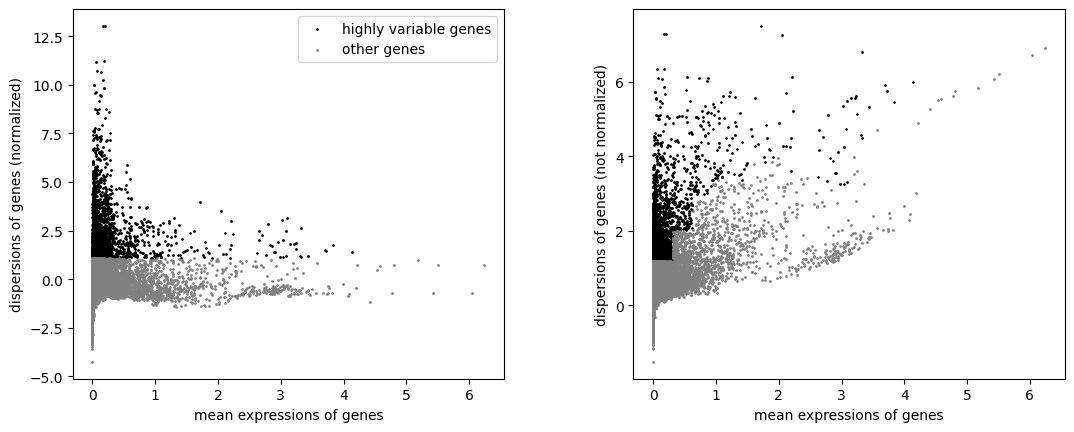

In [159]:
sc.pp.highly_variable_genes(adata, n_top_genes=2300)
sc.pl.highly_variable_genes(adata)

In [160]:
sc.pp.combat(adata, key='batch')

/Users/yihanyu/Library/Python/3.9/lib/python/site-packages/scanpy/preprocessing/_combat.py:351: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


In [161]:
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver = 'arpack')

In [9]:
!pip3 install igraph
!pip3 install leidenalg
!pip3 install louvain

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.8 MB 3.7 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.4 MB 3.7 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 185 kB 4.8 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [59]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, random_state=42)

In [60]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=46, random_state=42)
adata.obs['kmeans'] = kmeans.fit_predict(adata.obsm['X_pca']).astype(str)

In [74]:
sc.tl.louvain(adata, resolution=1.6, key_added="louvain")

In [76]:
sc.tl.leiden(adata, resolution=1.2, key_added="leiden")

In [63]:
sc.tl.umap(adata, min_dist=0.3, random_state=42)

In [64]:
import matplotlib.pyplot as plt
def visualize_cluster(adata, tag='', is_show=False):
    cluster_types = ["louvain", "leiden", "kmeans", "cluster"]
    titles = ["UMAP - Louvain Clusters", "UMAP - Leiden Clusters", 
              "UMAP - KMeans Clusters", "UMAP - True Clusters"]

    for cluster_type, title in zip(cluster_types, titles):
        sc.pl.umap(
            adata, color=cluster_type,
            title=title,
            legend_loc="right margin",
            size=10,
            alpha=0.7,
            frameon=False,
            show=is_show # 确保不直接显示，以便可以保存
        )
        if is_show:
            plt.show()
        else:
            plt.savefig(f"results/cluster_{cluster_type}_{tag}.png", bbox_inches='tight', dpi=300)
            plt.close() 

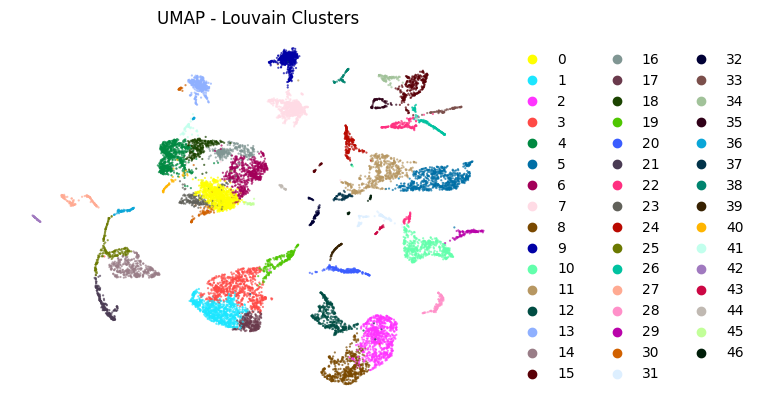

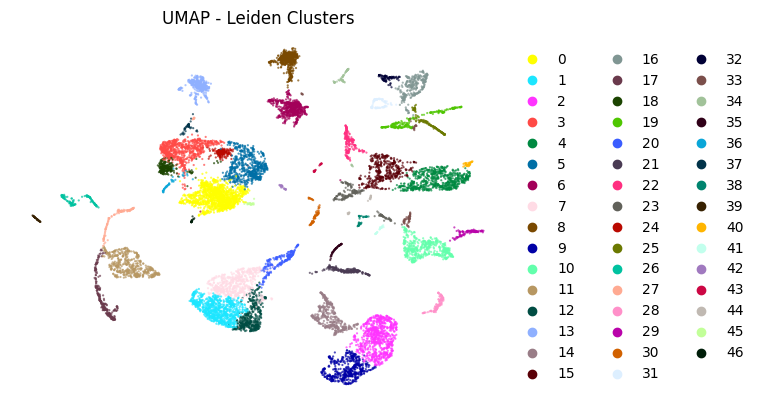

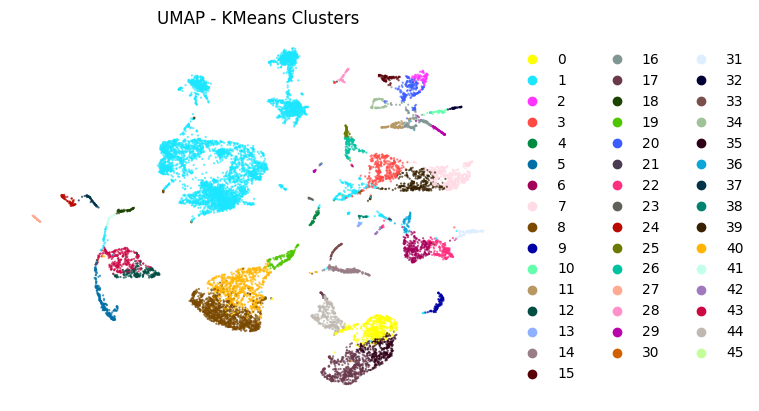

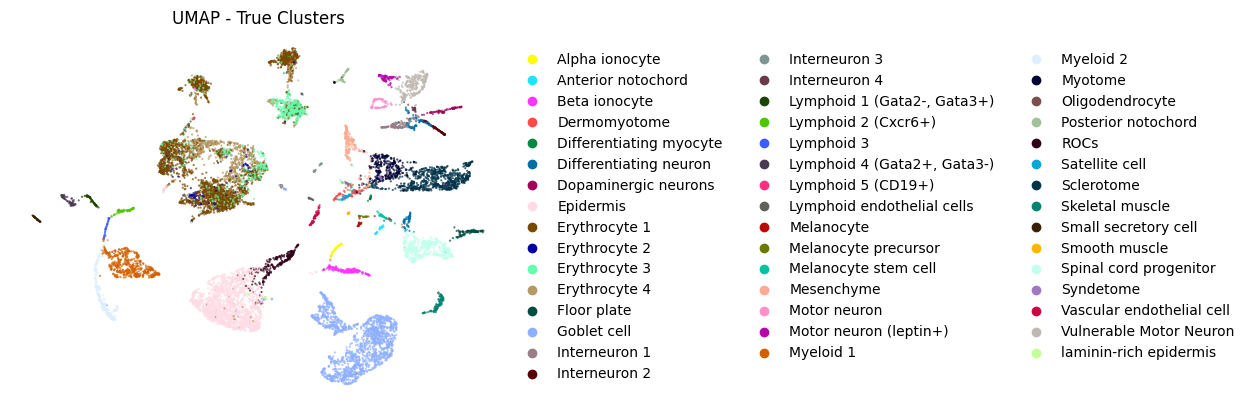

In [77]:
visualize_cluster(adata, is_show=True)

In [78]:
from sklearn.metrics import adjusted_rand_score, rand_score, silhouette_score, calinski_harabasz_score
def eval_cluster(adata, methods=["louvain", "leiden", "kmeans"]):
  if "cluster" in adata.obs.columns:
      true_labels = adata.obs["cluster"].astype(str)

      for method in methods:
          pred_labels = adata.obs[method]
          ari = adjusted_rand_score(true_labels, pred_labels)
          ri = rand_score(true_labels, pred_labels)
          sil = silhouette_score(adata.obsm["X_pca"], pred_labels.astype(int))
          ch = calinski_harabasz_score(adata.obsm["X_pca"], pred_labels.astype(int))
          print(f"=== {method.upper()} Clustering Metrics ===")
          print(f"Adjusted Rand Index (ARI): {ari:.3f}")
          print(f"Rand Index: {ri:.3f}")
          print(f"Silhouette Score: {sil:.3f}")
          print(f"Calinski-Harabasz Index: {ch:.3f}\n")
  else:
      print("False ground truth，only calculate silhouette, CH index")

In [79]:
eval_cluster(adata)

=== LOUVAIN Clustering Metrics ===
Adjusted Rand Index (ARI): 0.394
Rand Index: 0.921
Silhouette Score: 0.187
Calinski-Harabasz Index: 906.136

=== LEIDEN Clustering Metrics ===
Adjusted Rand Index (ARI): 0.412
Rand Index: 0.922
Silhouette Score: 0.205
Calinski-Harabasz Index: 931.004

=== KMEANS Clustering Metrics ===
Adjusted Rand Index (ARI): 0.476
Rand Index: 0.878
Silhouette Score: 0.464
Calinski-Harabasz Index: 1568.432



In [107]:
import anndata as ad
import scanpy as sc
extract_dir = "data/"
adata = ad.read_h5ad(extract_dir+'cleaned_processed_frogtail.h5ad') # ad.read_h5ad()
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=200)

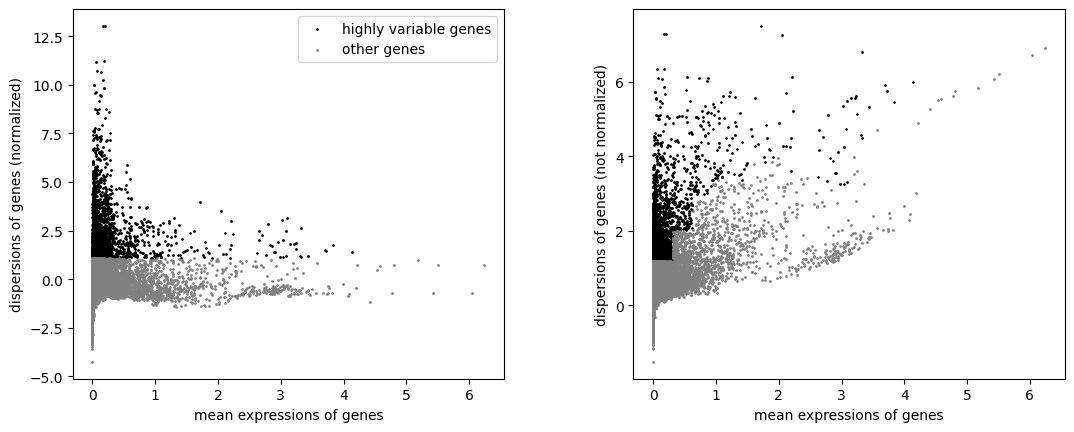

In [108]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2300)
sc.pl.highly_variable_genes(adata)
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver = 'arpack')

In [80]:
!pip3 install bbknn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 647 kB 5.9 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 38.5 MB/s eta 0:00:01
  Created wheel for annoy: filename=annoy-1.17.3-cp39-cp39-macosx_10_12_universal2.whl size=117551 sha256=69325a438300504e2f991ea054cea70c333b7af7035a43ce166c53ba89680016
  Stored in directory: /Users/yihanyu/Library/Caches/pip/wheels/09/a9/54/37478e65995fe712f7da465749da9ddb21db6b1a599d591ac7
Successfully built annoy
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [126]:
import bbknn
bbknn.bbknn(adata, batch_key='batch', neighbors_within_batch=5, n_pcs=40)

In [127]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=46, random_state=42)
adata.obs['kmeans'] = kmeans.fit_predict(adata.obsm['X_pca']).astype(str)

In [153]:
sc.tl.louvain(adata, resolution=1.252, key_added="louvain")

In [154]:
sc.tl.leiden(adata, resolution=1.252, key_added="leiden")

In [142]:
sc.tl.umap(adata, min_dist=0.8, spread=1.2, random_state=42)

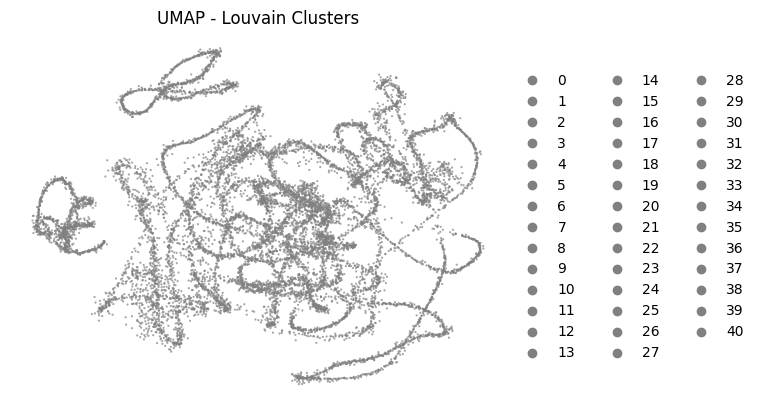

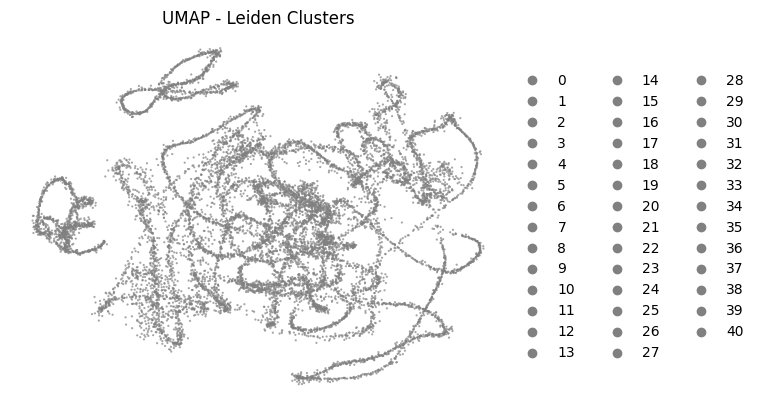

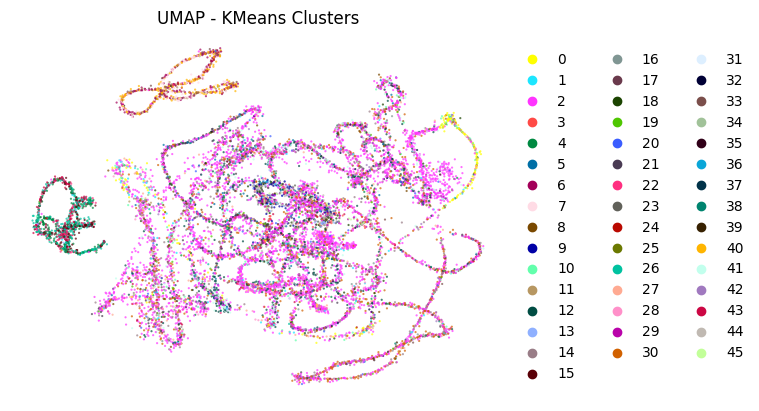

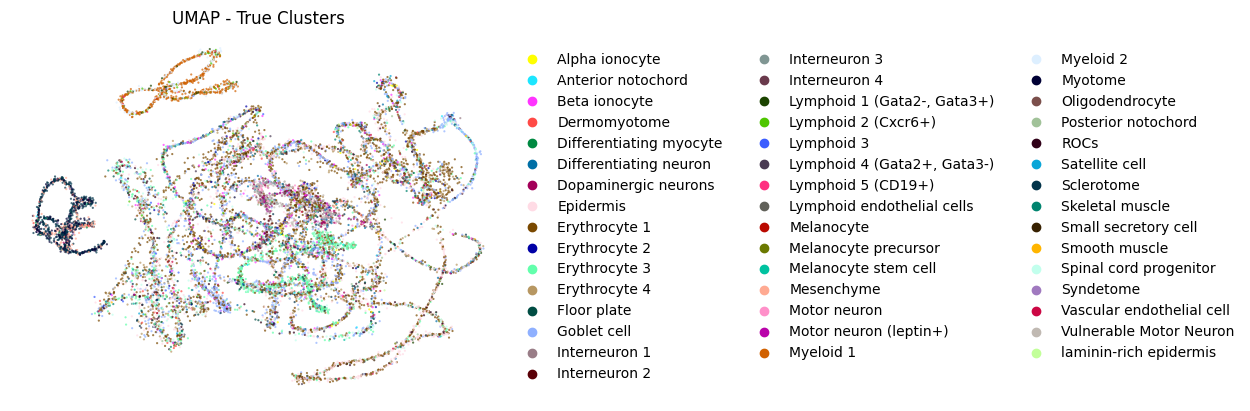

In [155]:
visualize_cluster(adata, is_show=True)

In [156]:
eval_cluster(adata)

=== LOUVAIN Clustering Metrics ===
Adjusted Rand Index (ARI): 0.104
Rand Index: 0.445
Silhouette Score: -0.584
Calinski-Harabasz Index: 117.062

=== LEIDEN Clustering Metrics ===
Adjusted Rand Index (ARI): 0.104
Rand Index: 0.445
Silhouette Score: -0.584
Calinski-Harabasz Index: 117.062

=== KMEANS Clustering Metrics ===
Adjusted Rand Index (ARI): 0.481
Rand Index: 0.879
Silhouette Score: 0.504
Calinski-Harabasz Index: 1859.406



In [162]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
from functools import reduce
from collections import defaultdict, Counter

sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi=120)

In [163]:
import os
extract_dir = "data/"
supp_table_path = os.path.join(extract_dir, "aav9996_tables3.xlsx")
output_dir = extract_dir+"results"
os.makedirs(output_dir, exist_ok=True)

In [164]:
def load_supp_table_3(filepath):
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"No file: {filepath}")

    df = pd.read_excel(filepath, sheet_name='ROC markers', header=None)
    genes = df.iloc[:, 0].dropna().astype(str).str.strip().tolist()
    genes = [g for g in genes if g != 'nan']
    print(f"# of genes in Supplementary Table 3: {len(genes)} ")
    gene_set = set(genes)
    print(f"# of unique genes in Supplementary Table 3: {len(gene_set)} ")
    return gene_set

def find_marker_genes(adata, groupby='cluster', methods=['logreg', 'wilcoxon'], n_markers=100):
    target_cluster = 'ROCs'
    results = {}

    for method in methods:
        print(f"Finding markers for '{target_cluster}' using {method}...")
        sc.tl.rank_genes_groups(
            adata, groupby=groupby, method=method,
            key_added=f'rank_genes_{method}'
        )
        df = sc.get.rank_genes_groups_df(adata, group=target_cluster, key=f'rank_genes_{method}')
        df['abs_score'] = df['scores'].abs()
        top_genes = df.nlargest(n_markers, 'abs_score')['names'].tolist()
        results[method] = {target_cluster: set(top_genes)}

    print("Finished!")
    return results

In [165]:
supp_genes = load_supp_table_3(supp_table_path)

# of genes in Supplementary Table 3: 50 
# of unique genes in Supplementary Table 3: 45 


In [166]:
marker_results_true = find_marker_genes(adata, groupby='cluster', methods=['logreg', 'wilcoxon'], n_markers=100)

Finding markers for 'ROCs' using logreg...
ranking genes
    finished (0:00:20)
Finding markers for 'ROCs' using wilcoxon...
ranking genes


/Users/yihanyu/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yihanyu/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yihanyu/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yihanyu/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yihanyu/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchange

    finished (0:02:07)


/Users/yihanyu/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yihanyu/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:461: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/yihanyu/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame

Finished!


In [167]:
def clean_gene_names(results):
    cleaned_results = {}
    
    for method, clusters in results.items():
        cleaned_clusters = {}
        for cluster, gene_set in clusters.items():
            cleaned_genes = {gene.split('.')[0] for gene in gene_set if isinstance(gene, str)}
            cleaned_clusters[cluster] = cleaned_genes
        cleaned_results[method] = cleaned_clusters
    
    return cleaned_results

marker_results_true_clean = clean_gene_names(marker_results_true)
print(marker_results_true_clean)

{'logreg': {'ROCs': {'lrrc17', 'col14a1', 'unc5b', 'lpar3', 'loc100490088', 'tcn2', 'npff', 'emx1', 'Xelaev18007571m', 'Xelaev18044969m', 'Xelaev18027412m', 'Xelaev18030545m', 'Xelaev18044182m', 'sp9', 'pltp', 'lama1', 'Xetrov90028158m', 'krt6', 'fscn2', 'kif26a', 'Xelaev18043128m', 'mxra5', 'tinagl1', 'ptgs1', 'loc100036800', 'fgf7', 'Xelaev18044179m', 'loc100488471', 'Xetrov90029035m', 'Xelaev18036901m', 'loc100127750', 'Xetrov90024587m', 'rdh10', 'Xelaev18046800m', 'Xelaev18005062m', 'Xelaev18026267m', 'fstl1', 'jag1', 'adamts20', 'dsg4', 'apoc1', 'arhgap22', 'Xelaev18035519m', 'Xelaev18022468m', 'cpa6', 'sema3f', 'bmp4', 'mmp3', 'nckap5l', 'lama5', 'fgf20', 'snx10', 'egfl6', 'Xetrov90020904m', 'Xelaev18033035m', 'fgfr4', 'col27a1', 'Xelaev18020334m', 'rspo2', 'loc100486967', 'krt17', 'Xelaev18011091m', 'fbn2', 'krt8', 'Xelaev18005859m', 'sp6', 'dlx2', 'wtip', 'henmt1', 'Xelaev18036903m', 'loc101732555', 'eva1b', 'gdf6', 'loc100492954', 'Xelaev18009361m', 'cyp26c1', 'fgf9', 'lef1', 

In [168]:
def compare_markers_with_supp(marker_results, supp_genes, output_dir=".", tag=""):
    cluster = 'ROCs'  
    methods = list(marker_results.keys())

    method_markers = {}
    for method in methods:
        method_markers[method] = marker_results[method].get(cluster, set())

    venn_data = {method: method_markers[method] for method in methods}
    global_inter = reduce(set.intersection, [method_markers[method] for method in methods])
    global_inter_supp = global_inter & supp_genes
    comparison_data = []
    row = {'cluster': cluster}
    found_any = False

    for method in methods:
        markers = method_markers[method]
        overlap = markers & supp_genes
        row[f"{method}_n_markers"] = len(markers)
        row[f"{method}_in_supp"] = len(overlap)
        row[f"{method}_genes_in_supp"] = ", ".join(sorted(overlap))
        if overlap:
            found_any = True
    inter_with_supp = global_inter & supp_genes
    row['intersection_n'] = len(global_inter)
    row['intersection_in_supp'] = len(inter_with_supp)
    row['intersection_genes_in_supp'] = ", ".join(sorted(inter_with_supp))

    if found_any:
        comparison_data.append(row)

    comp_df = pd.DataFrame(comparison_data)
    csv_path = os.path.join(output_dir, f"marker_comparison_with_supp_{tag}.csv")
    comp_df.to_csv(csv_path, index=False)
    print(f"Results saved: {csv_path}")
    print(f"Common marker genes: {len(global_inter)}")
    print(f"In Supp Table 3: {len(global_inter_supp)} → {sorted(global_inter_supp)}")

    return global_inter, comp_df, venn_data

In [169]:
global_inter, comp_df, venn_data = compare_markers_with_supp(marker_results_true_clean, supp_genes, output_dir)

Results saved: data/results/marker_comparison_with_supp_.csv
Common marker genes: 24
In Supp Table 3: 5 → ['egfl6', 'frem2', 'lpar3', 'nid2', 'pltp']
